In [ ]:
!pip install torch torchvision pandas numpy matplotlib seaborn scikit-learn pillow

Using device: cuda
GPU: Tesla T4
CUDA version: 12.4
Loading dataset...
Training samples: 1222
Test samples: 341

Class distribution:
soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64

Split sizes:
Training: 977
Validation: 245

Model architecture:
SoilClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm

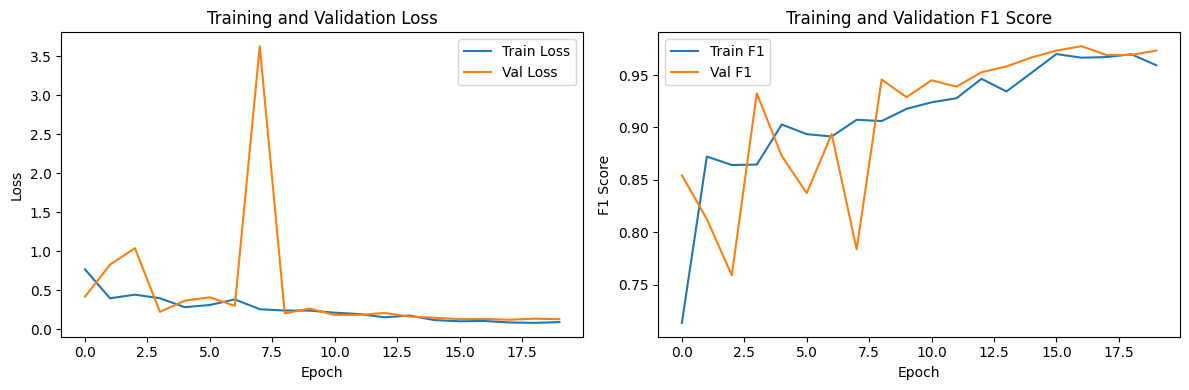


Final evaluation:
Classification Report:
               precision    recall  f1-score   support

Alluvial soil       1.00      0.96      0.98       106
   Black Soil       0.94      1.00      0.97        46
    Clay soil       0.95      0.97      0.96        40
     Red soil       0.98      0.98      0.98        53

     accuracy                           0.98       245
    macro avg       0.97      0.98      0.97       245
 weighted avg       0.98      0.98      0.98       245


F1 scores per class:
Alluvial soil: 0.9808
Black Soil: 0.9684
Clay soil: 0.9630
Red soil: 0.9811

Minimum F1 score (competition metric): 0.9630


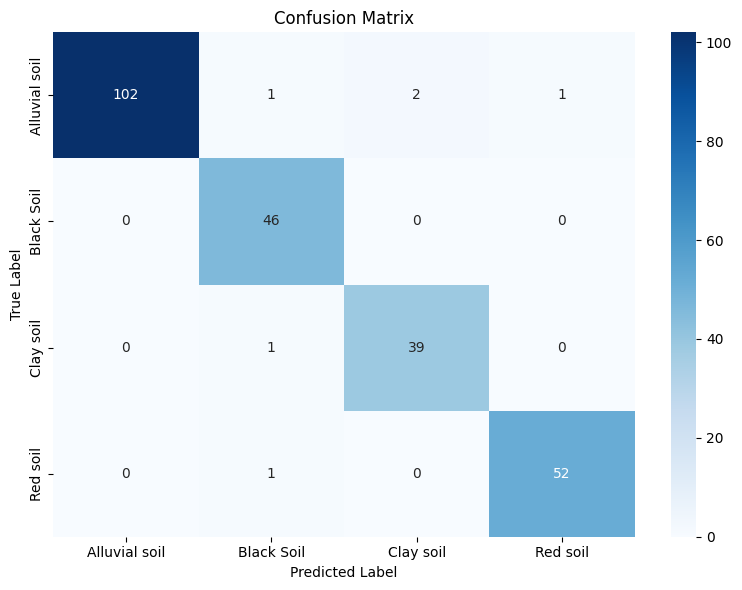


Generating test predictions...
Submission saved to 'submission.csv'
Final minimum F1 score: 0.9630
Model saved to 'soil_classifier_model.pth'


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class SoilDataset(Dataset):
    """Custom Dataset class for soil images"""
    
    def __init__(self, image_ids, labels, image_dir, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform
        
        # Create label mapping
        self.label_to_idx = {
            'Alluvial soil': 0,
            'Black Soil': 1, 
            'Clay soil': 2,
            'Red soil': 3
        }
        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id)
        
        # Handle missing files or different extensions
        try:
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            # Try alternative extension if original fails
            if image_id.endswith('.jpg'):
                alt_path = os.path.join(self.image_dir, image_id.replace('.jpg', '.jpeg'))
            elif image_id.endswith('.jpeg'):
                alt_path = os.path.join(self.image_dir, image_id.replace('.jpeg', '.jpg'))
            else:
                raise
            
            try:
                image = Image.open(alt_path).convert('RGB')
            except:
                # Create dummy image if file still not found
                print(f"Warning: Could not load {image_id}, using dummy image")
                image = Image.new('RGB', (224, 224), color=(128, 128, 128))
        
        if self.transform:
            image = self.transform(image)
        
        if self.labels is not None:
            label = self.label_to_idx[self.labels[idx]]
            return image, label
        else:
            return image

class SoilClassifier(nn.Module):
    """ResNet50-based classifier for soil classification"""
    
    def __init__(self, num_classes=4, dropout_rate=0.5):
        super(SoilClassifier, self).__init__()
        
        # Load pre-trained ResNet50
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        
        # Replace the final classifier
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

def load_data():
    """Load and explore the dataset"""
    print("Loading dataset...")
    
    # Updated paths for Kaggle
    base_path = '/kaggle/input/soil-classfication/soil-classification/soil_classification-2025'
    train_df = pd.read_csv(f'{base_path}/train_labels.csv')
    test_df = pd.read_csv(f'{base_path}/test_ids.csv')
    
    print(f"Training samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    print(f"\nClass distribution:")
    print(train_df['soil_type'].value_counts())
    
    return train_df, test_df

def create_transforms():
    """Create data augmentation transforms"""
    
    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Validation/Test transforms without augmentation
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def train_model(model, train_loader, val_loader, device, num_epochs=15):
    """Train the model with validation"""
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    best_val_f1 = 0.0
    best_model_state = None
    train_losses, val_losses = [], []
    train_f1s, val_f1s = [], []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_targets = [], []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
        
        scheduler.step()
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_f1 = f1_score(train_targets, train_preds, average='macro')
        val_f1 = f1_score(val_targets, val_preds, average='macro')
        
        # Calculate minimum F1 score (competition metric)
        val_f1_per_class = f1_score(val_targets, val_preds, average=None)
        val_min_f1 = np.min(val_f1_per_class)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Min F1: {val_min_f1:.4f}')
        print(f'Per-class F1: {val_f1_per_class}')
        print('-' * 60)
        
        # Save best model based on minimum F1 score
        if val_min_f1 > best_val_f1:
            best_val_f1 = val_min_f1
            best_model_state = model.state_dict().copy()
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses, train_f1s, val_f1s

def evaluate_model(model, val_loader, device):
    """Evaluate model and show detailed metrics"""
    
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    # Calculate metrics
    class_names = ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
    
    print("Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_names))
    
    # F1 scores per class
    f1_per_class = f1_score(all_targets, all_preds, average=None)
    min_f1 = np.min(f1_per_class)
    
    print(f"\nF1 scores per class:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {f1_per_class[i]:.4f}")
    print(f"\nMinimum F1 score (competition metric): {min_f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return min_f1

def predict_test_set(model, test_loader, device):
    """Generate predictions for test set"""
    
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
    
    return predictions

def main():
    """Main training and prediction pipeline"""
    
    # Set device for Kaggle GPU T4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"CUDA version: {torch.version.cuda}")
    
    # Load data
    train_df, test_df = load_data()
    
    # Create transforms
    train_transform, val_transform = create_transforms()
    
    # Split training data into train/validation
    train_data, val_data = train_test_split(
        train_df, test_size=0.2, random_state=42, 
        stratify=train_df['soil_type']
    )
    
    print(f"\nSplit sizes:")
    print(f"Training: {len(train_data)}")
    print(f"Validation: {len(val_data)}")
    
    # Updated paths for Kaggle datasets
    base_path = '/kaggle/input/soil-classfication/soil-classification/soil_classification-2025'
    
    # Create datasets
    train_dataset = SoilDataset(
        train_data['image_id'].values,
        train_data['soil_type'].values,
        f'{base_path}/train',  # Updated path
        transform=train_transform
    )
    
    val_dataset = SoilDataset(
        val_data['image_id'].values,
        val_data['soil_type'].values,
        f'{base_path}/train',  # Updated path
        transform=val_transform
    )
    
    test_dataset = SoilDataset(
        test_df['image_id'].values,
        None,
        f'{base_path}/test',  # Updated path
        transform=val_transform
    )
    
    # Optimized data loaders for Kaggle T4 GPU
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
    
    # Initialize model
    model = SoilClassifier(num_classes=4).to(device)
    
    print(f"\nModel architecture:")
    print(model)
    
    # Train model with more epochs for better performance
    print(f"\nStarting training...")
    model, train_losses, val_losses, train_f1s, val_f1s = train_model(
        model, train_loader, val_loader, device, num_epochs=20  # Increased epochs
    )
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1')
    plt.plot(val_f1s, label='Val F1')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate model
    print(f"\nFinal evaluation:")
    final_min_f1 = evaluate_model(model, val_loader, device)
    
    # Generate test predictions
    print(f"\nGenerating test predictions...")
    test_predictions = predict_test_set(model, test_loader, device)
    
    # Create submission file matching sample format
    idx_to_label = {0: 'Alluvial soil', 1: 'Black Soil', 2: 'Clay soil', 3: 'Red soil'}
    pred_labels = [idx_to_label[pred] for pred in test_predictions]
    
    submission_df = pd.DataFrame({
        'image_id': test_df['image_id'],
        'soil_type': pred_labels
    })
    
    submission_df.to_csv('submission.csv', index=False)
    print(f"Submission saved to 'submission.csv'")
    print(f"Final minimum F1 score: {final_min_f1:.4f}")
    
    # Save model
    torch.save(model.state_dict(), 'soil_classifier_model.pth')
    print("Model saved to 'soil_classifier_model.pth'")

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import os

def format_submission():
    """Format submission to match sample submission format exactly"""
    
    # Load the generated submission
    submission_df = pd.read_csv('submission.csv')
    
    # Load sample submission to understand the expected format
    sample_df = pd.read_csv('/kaggle/input/soil-classfication/soil-classification/soil_classification-2025/sample_submission.csv')
    
    print("Original submission format:")
    print(submission_df.head())
    print(f"\nOriginal submission shape: {submission_df.shape}")
    
    print("\nSample submission format:")
    print(sample_df.head())
    print(f"Sample submission shape: {sample_df.shape}")
    
    # Check if image_ids match exactly
    original_image_ids = set(submission_df['image_id'])
    sample_image_ids = set(sample_df['image_id'])
    
    print(f"\nImage ID comparison:")
    print(f"Images in original: {len(original_image_ids)}")
    print(f"Images in sample: {len(sample_image_ids)}")
    
    # Check for any discrepancies
    missing_in_original = sample_image_ids - original_image_ids
    extra_in_original = original_image_ids - sample_image_ids
    
    if missing_in_original:
        print(f"Missing in original: {missing_in_original}")
    if extra_in_original:
        print(f"Extra in original: {extra_in_original}")
    
    # Ensure the submission follows the exact order of the sample
    # Create a mapping from sample to preserve order
    sample_order = sample_df['image_id'].tolist()
    
    # Reorder submission to match sample order if available
    if len(sample_order) == len(submission_df):
        # Create a mapping of image_id to soil_type from our predictions
        prediction_map = dict(zip(submission_df['image_id'], submission_df['soil_type']))
        
        # Create new submission with sample order
        formatted_submission = pd.DataFrame({
            'image_id': sample_order,
            'soil_type': [prediction_map.get(img_id, 'Alluvial soil') for img_id in sample_order]
        })
    else:
        # If different lengths, keep original
        formatted_submission = submission_df.copy()
    
    # Validate soil types are correct
    valid_soil_types = {'Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil'}
    invalid_types = set(formatted_submission['soil_type']) - valid_soil_types
    
    if invalid_types:
        print(f"Warning: Invalid soil types found: {invalid_types}")
        # Fix any invalid types
        formatted_submission['soil_type'] = formatted_submission['soil_type'].apply(
            lambda x: x if x in valid_soil_types else 'Alluvial soil'
        )
    
    # Save formatted submission
    formatted_submission.to_csv('formatted_submission.csv', index=False)
    
    print(f"\nFormatted submission saved!")
    print(f"Final submission shape: {formatted_submission.shape}")
    print("\nFinal submission preview:")
    print(formatted_submission.head(10))
    
    # Verify the format matches sample
    print(f"\nSoil type distribution in final submission:")
    print(formatted_submission['soil_type'].value_counts())
    
    return formatted_submission

def validate_submission():
    """Additional validation of the submission file"""
    
    try:
        # Load and validate the formatted submission
        submission = pd.read_csv('formatted_submission.csv')
        
        # Check required columns
        required_cols = ['image_id', 'soil_type']
        if not all(col in submission.columns for col in required_cols):
            print("❌ Missing required columns!")
            return False
        
        # Check for null values
        if submission.isnull().any().any():
            print("❌ Found null values in submission!")
            return False
        
        # Check soil types
        valid_types = {'Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil'}
        invalid = set(submission['soil_type']) - valid_types
        if invalid:
            print(f"❌ Invalid soil types: {invalid}")
            return False
        
        # Check for duplicate image_ids
        if submission['image_id'].duplicated().any():
            print("❌ Found duplicate image IDs!")
            return False
        
        print("✅ Submission validation passed!")
        print(f"✅ Total predictions: {len(submission)}")
        print(f"✅ Unique images: {submission['image_id'].nunique()}")
        
        return True
        
    except Exception as e:
        print(f"❌ Error validating submission: {e}")
        return False

if __name__ == "__main__":
    print("🔄 Formatting submission to match sample format...")
    formatted_df = format_submission()
    
    print("\n🔍 Validating formatted submission...")
    is_valid = validate_submission()
    
    if is_valid:
        print("\n🎉 Submission is ready for upload!")
        print("📁 File: formatted_submission.csv")
    else:
        print("\n❌ Please fix the issues before submitting!")